<a href="https://colab.research.google.com/github/KevinHuang8/CS159-WTA/blob/master/DQN_1D_BuildUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import numpy as np
import math
import random
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from gym import error, spaces, utils
from gym.utils import seeding

# Create a custom environment 
class WTAEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, target_values, prob, device):
        """Assignment - m x n array that maps weapons to assigned target, where
        the assigned target is one-hot encoded to differentiate between unassigned
        weapons (row is all zero's) and assigned weapons (exactly one column 
        index of row is 1)

        Input:
        target_values - 1D array that maps targets to their value when destroyed
        prob - m x n array where prob[i, j] = probability of weapon i killing target j"""
        super(WTAEnv, self).__init__()

        # Initialization
        self.n = len(target_values)
        self.m = len(prob)
        self.assignment = self.generate_initial_assignment()
        self.target_values = target_values 
        self.prob = prob
        # q = probability array of survival
        self.q = 1 - self.prob
        self.value = self.assignment_value()

        # Keep track of the assigned weapons. Index i is 1 if 
        # weapon i is already assigned, 0 if it is unassigned. Used in order
        # to set probabilities of infeasible weapon-target assignments to 0
        self.weapons_assigned = np.zeros(self.m)
        
        # The action space - a number 0 <= i < m * n, where
        # (weapon = i // n, target = i % n)
        # Assigns weapon to target (one target per weapon)
        self.action_space = spaces.MultiDiscrete([self.m, self.n])
        self.device = device

    def generate_initial_assignment(self):
        """
        Start with all weapons unassigned.
        """  
        return np.zeros((self.m, self.n)).astype(np.int32)
        
    def decode_action(self, action):
        """
        Interpret an action.

        Input: an action.
        
        Output: the weapon and target associated with
        that action.
        """
        return action // self.n, action % self.n

    def step(self, action):
        """
        Pick a random action, update the remaining weapons, and return the reward.

        Input: an action.

        Output: reward (the expected value of the chosen weapon killing its target
        multiplied by the value of the target)
        """
        weapon, target = self.decode_action(action[0][0])
        if not self.action_space.contains([weapon, target]):
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        
        # Update the weapons remaining and the assignment
        self.weapons_assigned[weapon] = 1
        self.assignment[weapon][target] = 1

        # Reward used to be multiplying the expected value of the chosen weapon
        # killing  the chosen target times the value of the target. But this isn't
        # consistent with the way the reward of an entire assignment is computed
        # reward = self.prob[weapon][target] * self.target_values[target]

        # Reward is change in assignment value
        new_value = self.assignment_value()
        reward = new_value - self.value
        self.value = new_value

        done = np.sum(self.weapons_assigned) == self.m
        return (self.get_state(), reward, done, {})
    
    def assignment_value(self):
        '''
        Compute the expected value of our assignment.
        E = Sum over targets i [P(target i killed) * Value(i)]
        where P(target i killed) = 1 - P(i survives)
        where P(i surves) = 1 - Product over weapons j [P(i survives j) = q[i, j]]
        '''
        pkill = 1 - np.prod(self.q ** self.assignment, axis=0)
        expected_value = np.dot(pkill, self.target_values)
        return expected_value

    def get_state(self):
        """
        First flatten the matrix of one-hot encoded assignment to get 1D vector
        of length m * n. Then append the matrix of weapons_remaining
        Our state is a size m * n + m + n array.
        state[:m*n] is self.assignments
        state[m*n:m*n+m] is the number of weapons left 
        state[m*n+m:] is self.target_values

        Output: the state.
        """
        flat_assign = self.assignment.flatten()
        state = np.concatenate([flat_assign, self.weapons_assigned, self.target_values])
        # Return state as a tensor and add a batch dimension
        return torch.tensor(state, device=self.device).unsqueeze(0)

    def reset(self):
        """
        Important: the observation must be a numpy array
        
        return: numpy array of the state.
        """
        self.assignment = self.generate_initial_assignment()
        self.weapons_assigned = np.zeros(self.m)
        return self.get_state()

    def render(self, mode='human', close=False):
        pass

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        """
        Initialization
        """
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
steps_done = 0

def select_action(state, weapons_assigned, n, m, is_testing):
    """
    Selects an action.

    Input: state, assignment of weapons, n, m

    Output: torch tensor of the action
    """
    global steps_done
    sample = random.random()
    if not is_testing:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
    else:
        # when testing, always use the neural net to select
        # an action
        eps_threshold = 0
    weapons_tensor = torch.tensor(weapons_assigned)
    if sample > eps_threshold:
      with torch.no_grad():
        policy_net.eval()
        nn_prob = policy_net(state)
        policy_net.train()
        ind = torch.max(nn_prob, dim = 1)[1]
        return torch.tensor([[ind]], device=device, dtype=torch.int)
    else:
      weapons_left = (weapons_tensor == 0).nonzero().flatten()
      weapon = np.random.choice(weapons_left.numpy())
      target = random.randrange(n)
      ind = weapon * n + target
      return torch.tensor([[ind]], device=device, dtype=torch.int)

episode_durations = []

def plot_durations(ep):
    """
    Visual representation.
    """
    fig = plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        # if ep % 5 == 0:
        #   fig.savefig('episode{}'.format(ep))

In [0]:
def optimize_model(memory):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(dim=1, index =action_batch.long())

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.double(), expected_state_action_values.unsqueeze(1).double())
    value_loss = loss.item()
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return value_loss

In [0]:
"""Take in n by m matrix, convert it to 1D feature vector """
class DQN(nn.Module):
    def __init__(self, n, m):
        """
        Initialization.

        Input: n, m, and the embedding size.
        """
        super(DQN, self).__init__()
        # The assignment is one-hot encoded and then passed in as a flattened
        # vector
        self.assignment_size = m * n
        # The input consists of the current partial assignment, with the 
        # n target values appended to the end
        self.input_size = self.assignment_size + n
        self.n = n
        self.m = m
        self.mask_val = -2 ** 30
          
        units = 50
        # Return the probabilities of making a new assignment of weapon 
        # m to target n
        self.output_size = m * n
        self.lin1 = nn.Linear(self.input_size, units)
        self.drop1 = nn.Dropout(0.2)
        self.lin2 = nn.Linear(units, self.assignment_size)
        self.drop2 = nn.Dropout(0.2)

    def forward(self, state):
        """
        Called with either one element to determine next action, or a batch
        during optimization. Returns tensor([[left0exp,right0exp]...]).
        """
        end_assign = self.assignment_size
        assignment = state[:, :end_assign].float()
        assigned = state[:, end_assign:(end_assign + self.m)].int()
        values = state[:, (end_assign + self.m):].float()
        # Append the target values
        x = torch.cat([assignment, values], dim=1)
        x = F.relu(self.drop1(self.lin1(x)))
        x = F.relu(self.drop2(self.lin2(x)))
        # Mask out weapons that have already been assigned by adding a large
        # negative number 
        mask = assigned.unsqueeze(-1).repeat(1, 1, self.n).view(assigned.shape[0], -1)
        mask *= self.mask_val 
        x = x.add(torch.tensor(mask))
        return x

In [0]:
# with dueling networks
class DuelingDQN(nn.Module):
    def __init__(self, n, m, units=128):
        super(DuelingDQN, self).__init__()
        # The assignment is one-hot encoded and then passed in as a flattened
        # vector
        self.assignment_size = m * n
        # The input consists of the current partial assignment, with the 
        # n target values appended to the end
        self.input_size = self.assignment_size + n
        self.n = n
        self.m = m
        self.mask_val = -2 ** 30
          
        self.units = units
        # Return the probabilities of making a new assignment of weapon 
        # m to target n
        self.output_size = m * n
        self.lin1 = nn.Linear(self.input_size, units)
        self.drop1 = nn.Dropout(0.2)
        self.lin2 = nn.Linear(units, self.output_size)
        self.drop2 = nn.Dropout(0.2)

        # Layer to measure the value of a state
        self.value_stream = nn.Sequential(
            nn.Linear(self.input_size, units),
            nn.ReLU(),
            nn.Linear(units, 1)
        )
        # Layer to measure the advantages of an action given a state
        self.advantage_stream = nn.Sequential(
            nn.Linear(self.input_size, units),
            nn.ReLU(),
            nn.Linear(units, self.output_size)
        )

    def forward(self, state):
        end_assign = self.assignment_size
        assignment = state[:, :end_assign].float()
        assigned = state[:, end_assign:(end_assign + self.m)].int()
        target_values = state[:, (end_assign + self.m):].float()
        # Append the target values and concatenate the values
        x = torch.cat([assignment, target_values], dim=1)
        # Get the value of the state
        values = self.value_stream(x)
        advantages = self.advantage_stream(x)
        qvals = values + (advantages - advantages.mean())
        # Mask out weapons that have already been assigned by adding a large
        # negative number 
        mask = assigned.unsqueeze(-1).repeat(1, 1, self.n).view(assigned.shape[0], -1)
        mask *= self.mask_val 
        qvals = qvals.add(torch.tensor(mask))
        return qvals

    def feature_size(self):
        return self.conv(autograd.Variable(torch.zeros(1, *self.input_dim))).view(1, -1).size(1)

In [0]:
BATCH_SIZE = 128
GAMMA = 1
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 100

n = 4
m = 5
lower_val = 25
upper_val = 50
lower_prob = 0.6
upper_prob = 0.9
values = np.random.uniform(lower_val, upper_val, n)
prob = np.random.uniform(lower_prob, upper_prob, (m, n))
env = WTAEnv(values, prob, device)

policy_net = DQN(n, m).to(device)
target_net = DQN(n, m).to(device)

# DuelingDQN is broke, press F
# policy_net = DuelingDQN(n, m).to(device)
# target_net = DuelingDQN(n, m).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())

In [0]:
def train_model(n, m, prob, lower_val, upper_val, num_episodes = 50):
    ''' 
    Trains a DQN on problem instances with n targets and 
    m weapons, as well as the same killing probabilities, 
    prob. For each episode, randomly sample a new problem
    instance by sampling target values.
    '''
    memory = ReplayMemory(1000000)
    losses = []
    for i_episode in range(num_episodes):
        # Randomly sample target values over a uniform distribution
        values = np.random.uniform(lower_val, upper_val, n)
        # Initialize the environment and state 
        env = WTAEnv(values, prob, device)
        env.reset()
        state = env.get_state()
        for t in count():
            # print(f'episode {i_episode}/{num_episodes}, iteration {t}', end='\n')
            # Select and perform an action
            action = select_action(state, env.weapons_assigned, env.n, env.m, False)
            observation, reward, done, _ = env.step(action)
            reward = torch.tensor([reward], device=device)
            
            if not done:
                next_state = observation
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            loss = optimize_model(memory)
            if done:
              episode_durations.append(t + 1)
              # plot_durations(i_episode)
              break
        losses.append(loss)
        # Update the target network, copying all weights and biases in DQN
        # if i_episode % TARGET_UPDATE == 0:
        #     target_net.load_state_dict(policy_net.state_dict())

    # Just print out the last 10 values or so of loss
    print(losses[-10:])
    env.render()
    env.close()
    return losses

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[20.92005915416282, 20.476481843246013, 19.677015773747115, 19.204560484735396, 20.604078145181095, 18.70641836447259, 19.61572746572734, 19.57652025406109, 18.02186711671026, 20.93554173497418]


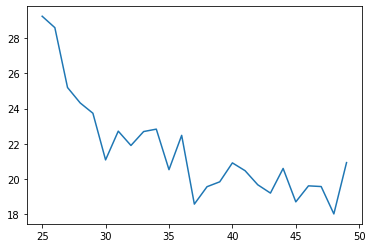

In [11]:
losses = train_model(4, 5, prob, 25, 100, 50)
x = np.arange(len(losses))
plt.plot(x, losses)
plt.show()

### Testing the model

In [12]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = '/content/drive/My Drive/WTA/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# read example file
def read_example_file(filename):
    with open(filename) as fp:
        n_targets = list(map(lambda x: int(x), fp.readline().split()))[0]
        n_weapons = n_targets
        values = []
        for i in range(n_targets):
            values.append(float(fp.readline()))

        probabilities = []
        for i in range(n_weapons):
            probabilities.append([])
            for j in range(n_targets):
                probabilities[i].append(float(fp.readline()))
    return n_targets, n_weapons, values, np.asarray(probabilities)

def get_int_assignment(one_hot):
    assignment = []
    for i in range(len(one_hot)):
        assignment.append(np.flatnonzero(one_hot[i])[0])
    return assignment

def reward(assignment, n_targets, n_weapons, values, probabilities, one_hot):
    survival_probabilities = [1] * n_targets
    # Convert the one-hot encoded assignments to int
    if one_hot:
        assignment = get_int_assignment(assignment)
    for i in range(n_weapons):
        survival_probabilities[assignment[i]] *= 1 - probabilities[i][assignment[i]]
    reward = 0
    for j in range(n_targets):
        reward += values[j] * (1 - survival_probabilities[j])
    return reward

def test_model(test_env):
    done = False
    while not done:
        action = select_action(test_env.get_state(), \
                               test_env.weapons_assigned, test_env.n, test_env.m, True)
        observation, reward, done, _ = test_env.step(action)
    return test_env.assignment

def plot_losses(losses, fname):
    x = np.arange(len(losses))
    plt.plot(x, losses)
    plt.savefig(fname)
    plt.clf()

In [0]:
for i in range(12, 13):
    file = prefix + 'data/WTA' + str(i)
    n_targets, n_weapons, values, probabilities = read_example_file(file)
    lower_val = min(values)
    upper_val = max(values)
    
    # Initialize the policy neural net, target, neural net, optimizer
    policy_net = DQN(n_targets, n_weapons).to(device)
    target_net = DQN(n_targets, n_weapons).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.RMSprop(policy_net.parameters())
    # Reset the number  of steps to 0
    steps_done = 0
    
    # Train the model. Larger instances need more episodes to train over
    # though this means it will take much longer to train them
    num_episodes = n_targets * 10 if n_targets < 50 else 500
    losses = train_model(n_targets, n_weapons, probabilities, lower_val, upper_val, num_episodes)
    
    # Plot losses and save models
    plot_losses(losses, prefix + "/results/example"+str(i))
    model_save_name = 'DQN' + str(i)
    path = F"models/{model_save_name}" 
    torch.save(policy_net.state_dict(), prefix + path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [22]:
# Run the model on the actual test instance
rewards = []
for i in range(1, 13):
    model_path = prefix + 'models/DQN' + str(i)
    file_path = prefix + 'data/WTA' + str(i)
    checkpoint = torch.load(model_path)
    n_targets, n_weapons, values, probabilities = read_example_file(file_path)
    policy_net = DQN(n_targets, n_weapons).to(device)
    policy_net.load_state_dict(checkpoint)
    policy_net.eval()
    test_env = WTAEnv(values, probabilities, device)
    assignment = test_model(test_env)
    print(assignment)
    inst_reward = reward(assignment, n_targets, n_weapons, values, probabilities, True)
    rewards.append(inst_reward)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [23]:
print(rewards)
with open(prefix + 'results/rewards.txt', 'w') as f:
    for val in rewards:
        f.write(str(val) + '\n')

[271.60042, 424.32449649292795, 645.736478812308, 1348.7045843200003, 1769.62080205, 2205.78054785, 2311.7931848069493, 3154.5531212999995, 3046.623840670009, 3914.2783342727803, 4566.622245776837, 7508.01276856903]


In [17]:
def generate_random_population(population_size, n_targets, n_weapons):
    population = []
    targets = list(range(n_targets))
    for i in range(population_size):
        assignment = [random.choice(targets) for _ in range(n_weapons)]
        population.append(assignment)
    return population

prefix = '/content/drive/My Drive/WTA/'
rewards = []
with open(prefix + 'results/rewards.txt', 'r') as f:
    for line in f:
        rewards.append(float(line))

# Compare rewards with randomly generated assignments
avg_scores = []
for i in range(1, 13):
    file = prefix + 'data/WTA' + str(i)
    n_targets, n_weapons, values, probabilities = read_example_file(file)
    num_sample = 100
    population = generate_random_population(num_sample, n_targets, n_weapons)
    sum_improv = 0
    for assign in population:
        inst_reward = reward(assign, n_targets, n_weapons, values, probabilities, False)
        # Calculate the percent of improvement from the reward of a randomly
        # generated assignment to that of the assignment generated by the model
        sum_improv += (rewards[i - 1] - inst_reward) / inst_reward
    avg_scores.append(sum_improv / num_sample)
print(avg_scores)

[0.388315102787385, 0.34877648437096537, 0.22332141131511807, 0.33859617363749683, 0.114327935109007, 0.3035525864767416]
